In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import holidays
from sklearn.model_selection import train_test_split

# Load the data
data_RF = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/imputed_data_RF.csv")
data_KNN = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/imputed_data_KNN.csv")

## Daten aufteilen

In [12]:
import os
import pandas as pd

# Daten mit Zeitreihenstruktur aufteilen
# Ensure the data is sorted by date
data = data_KNN.sort_values(by='Datum').dropna()
print(data_KNN.head())

# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
validation_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

# Check the dimensions of the datasets
print("Training dataset dimensions:", train_data.shape)
print("Validation dataset dimensions:", validation_data.shape)
print("Test dataset dimensions:", test_data.shape)


   Warengruppe      Umsatz  Bewoelkung  Temperatur  Windgeschwindigkeit  \
0          3.8  114.234794         8.0      9.8250                 14.0   
1          3.0  179.073824         7.0      7.4375                 12.0   
2          3.0  156.975990         8.0      5.5375                 18.0   
3          3.8  154.468579         4.0      5.6875                 19.0   
4          3.0  140.018154         6.0      5.3000                 23.0   

   Wettercode  Feiertag  Wochenende  Wochentag  Monat  ...  Bewoelkung_kat  \
0        58.0       1.0         1.0        6.0    1.0  ...             2.0   
1        65.0       0.0         0.0        0.0    1.0  ...             2.0   
2        63.0       0.0         0.0        1.0    1.0  ...             2.0   
3        80.0       0.0         0.0        2.0    1.0  ...             1.0   
4        80.0       0.0         0.0        3.0    1.0  ...             1.0   

   Windgeschwindigkeit_kat  Kalenderwoche  Jahreszeit  Umsatz_lag1  \
0         

## Daten speichern

In [13]:
# Define the file paths
subdirectory = "pickle_data"
if not os.path.exists(subdirectory):
    os.makedirs(subdirectory)

training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Assuming 'Umsatz' is the label and the rest are features
train_features = train_data.drop(columns=['Umsatz'])
train_labels = train_data['Umsatz']
validation_features = validation_data.drop(columns=['Umsatz'])
validation_labels = validation_data['Umsatz']
test_features = test_data.drop(columns=['Umsatz'])
test_labels = test_data['Umsatz']

# Save the datasets to pickle files
train_features.to_pickle(training_features_path)
train_labels.to_pickle(training_labels_path)
validation_features.to_pickle(validation_features_path)
validation_labels.to_pickle(validation_labels_path)
test_features.to_pickle(test_features_path)
test_labels.to_pickle(test_labels_path)

# Verify the saved data by reading the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())

Loaded Training features dimensions: (8070, 20)
Loaded Validation features dimensions: (1849, 20)
Loaded Test features dimensions: (366, 20)

Loaded Training labels dimensions: (8070,)
Loaded Validation labels dimensions: (1849,)
Loaded Test labels dimensions: (366,)

First few rows of loaded training features:
   Warengruppe  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0          3.8         8.0      9.8250                 14.0        58.0   
1          3.0         7.0      7.4375                 12.0        65.0   
2          3.0         8.0      5.5375                 18.0        63.0   
3          3.8         4.0      5.6875                 19.0        80.0   
4          3.0         6.0      5.3000                 23.0        80.0   

   Feiertag  Wochenende  Wochentag  Monat  Temp_abw  Bewoelkung_kat  \
0       1.0         1.0        6.0    1.0       1.0             2.0   
1       0.0         0.0        0.0    1.0       0.0             2.0   
2       0.0         0.0

## Daten zu numpy arrays machen

In [14]:
# Convert DataFrames to numpy arrays
training_features_array = training_features.to_numpy()
training_labels_array = training_labels.to_numpy().flatten()  # Flatten in case labels are a DataFrame with one column

print("Training Features Array:")
print(training_features_array[:5])

Training Features Array:
[[3.800000153001996 8.0 9.825 14.0 58.0 1.0 1.0 6.0 1.0 1.0 2.0 2.0 52.0
  1.0 979.664032371759 130.8197102818178 1.0 434.8545137155018 0.0
  '2012-01-01']
 [3.0 7.0 7.4375 12.0 65.0 0.0 0.0 0.0 1.0 0.0 2.0 2.0 1.0 1.0
  178.06834398765776 228.6564918468304 0.0 703.4201365959616 0.0
  '2012-01-02']
 [2.999999956064669 8.0 5.5375 18.0 63.0 0.0 0.0 1.0 1.0 0.0 2.0 3.0 1.0
  1.0 162.7664935402656 507.23326134746816 0.0 531.8473487430714 0.0
  '2012-01-03']
 [3.8 4.0 5.6875 19.0 80.0 0.0 0.0 2.0 1.0 0.0 1.0 3.0 1.0 1.0
  270.25101522683565 210.1287755101419 0.0 221.14440646619423 0.0
  '2012-01-04']
 [3.0 6.0 5.3 23.0 80.0 0.0 0.0 3.0 1.0 0.0 1.0 4.0 1.0 1.0
  131.27206779742895 173.27369159797396 0.0 260.6030703671655 0.0
  '2012-01-05']]


## Aufstellen des Modells

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

model = Sequential([
  InputLayer(input_shape=(training_features.shape[1], )),
  BatchNormalization(),
  Dense(10, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1)
])

model.summary()

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_5           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339 (1.32 KB)

 Trainable params: 299 (1.17 KB)

 Non-trainable params: 40 (160.00 B)

## Modell trainieren

In [17]:
# Funktion zur Entfernung von nicht-numerischen Spalten und Konvertierung
def preprocess_data(df):
    # Entfernen von datetime-Spalten
    df = df.select_dtypes(exclude=['datetime64[ns]'])
    # Konvertieren von allen verbleibenden Spalten zu numerischen Werten
    df = df.apply(pd.to_numeric, errors='coerce')
    # Entfernen von Spalten, die nach der Konvertierung nur noch NaNs enthalten
    df = df.dropna(axis=1, how='all')
    return df

# Vorverarbeitung der Daten
training_features = preprocess_data(training_features)
validation_features = preprocess_data(validation_features)
test_features = preprocess_data(test_features)

# Sicherstellen, dass alle Spalten numerisch sind
print("Datentypen der Trainingsdaten:")
print(training_features.dtypes)

# Sicherstellen, dass die Daten vorbereitet sind
print("Training features shape:", training_features.shape)

# Beispiel für die Erstellung eines einfachen neuronalen Netzwerks
# InputLayer an die Anzahl der Merkmale anpassen
model = Sequential([
    InputLayer(input_shape=(training_features.shape[1],)),  # Anzahl der Merkmale dynamisch anpassen
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(1)  # Ausgabe-Neuron für die Regression
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Modell trainieren
history = model.fit(training_features, training_labels, epochs=2,
                    validation_data=(validation_features, validation_labels))

print("Modell erfolgreich trainiert!")




Datentypen der Trainingsdaten:
Warengruppe                               float64
Bewoelkung                                float64
Temperatur                                float64
Windgeschwindigkeit                       float64
Wettercode                                float64
Feiertag                                  float64
Wochenende                                float64
Wochentag                                 float64
Monat                                     float64
Temp_abw                                  float64
Bewoelkung_kat                            float64
Windgeschwindigkeit_kat                   float64
Kalenderwoche                             float64
Jahreszeit                                float64
Umsatz_lag1                               float64
Umsatz_lag7                               float64
Feiertag_in_3_tagen                       float64
durchschnittlicher_Umsatz_vor_Feiertag    float64
Kieler_Woche                              float64
dtype: object
Train

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


253/253 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 63149.8164 - val_loss: 50106.6094
Epoch 2/2
253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55989.7109 - val_loss: 34453.4414
Modell erfolgreich trainiert!


## Modell speichern

In [18]:
model.save("python_model.h5")

## Modell Loss durchs Training plotten

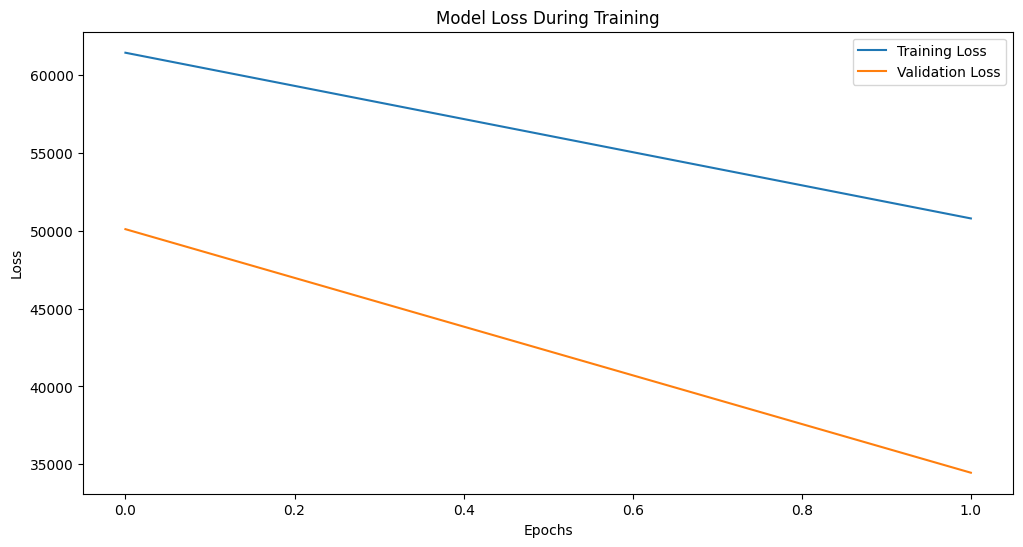

In [19]:
# Training history plotten
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predicitions aufstellen

In [20]:
# Predictions machen
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = model.predict(training_features)
validation_predictions = model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
MAPE on the Training Data: 81.07%
MAPE on the Validation Data: 81.53%


## Predictions plotten

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


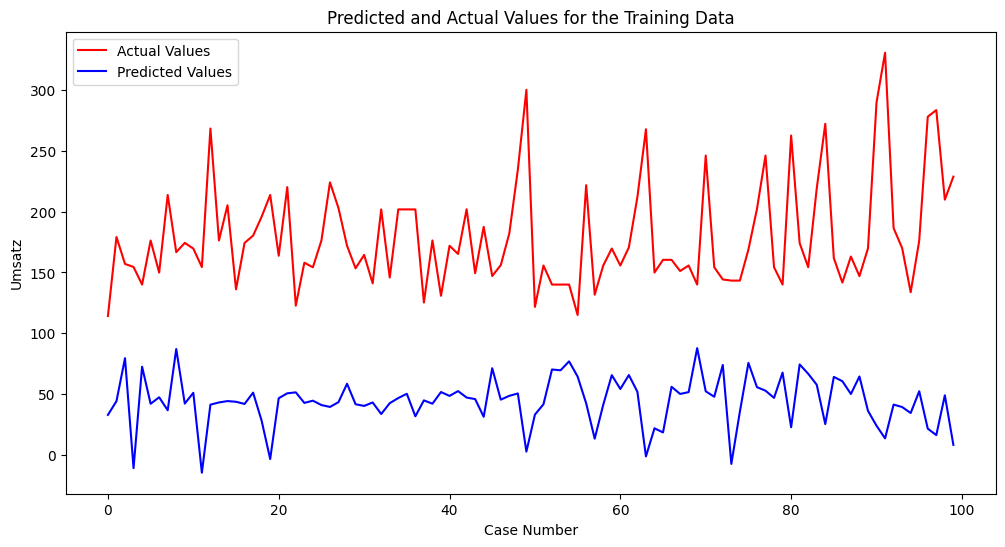

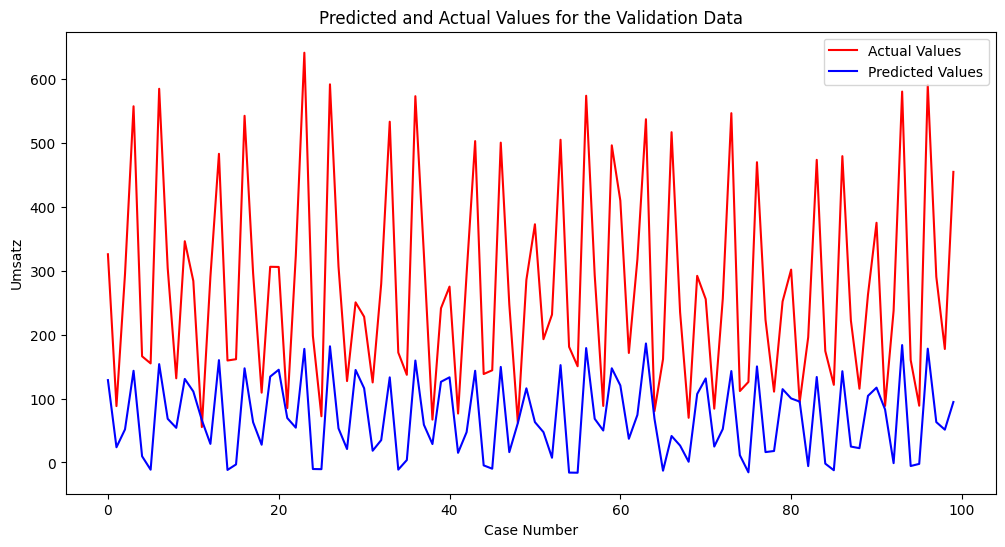

In [22]:
# Plotten
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Case Number')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')